# Day 5: Common Pitfalls & Overfitting

## Week 12 - Backtesting & Validation

### 🎯 Learning Objectives
- Identify and avoid lookahead bias
- Understand overfitting in financial ML
- Apply multiple testing corrections
- Detect strategy decay

### ⏱️ Time Allocation
- Theory review: 30 min
- Guided exercises: 90 min
- Practice problems: 60 min
- Interview prep: 30 min

---

**Author**: ML Quant Finance Mastery  
**Difficulty**: Intermediate  
**Prerequisites**: Day 1-4

## 1. Setup and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# Generate financial data
n_samples = 1500  # ~6 years

# Create features with different predictive power
df = pd.DataFrame({
    'momentum': np.random.randn(n_samples) * 0.01,
    'volatility': np.abs(np.random.randn(n_samples) * 0.015),
    'volume': np.random.randn(n_samples) * 0.02,
    'sentiment': np.random.randn(n_samples) * 0.01
})

# Target with weak predictability
df['target'] = (0.02 * df['momentum'] + 
                -0.01 * df['volatility'] + 
                np.random.randn(n_samples) * 0.015)

print(f"📊 Generated {n_samples} samples")
print(f"   Actual signal in target: ~2% from momentum, ~1% from volatility")

📊 Generated 1500 samples
   Actual signal in target: ~2% from momentum, ~1% from volatility


## 2. Lookahead Bias Demonstration

### Common Sources of Lookahead

1. **Future data in features**: Using tomorrow's data today
2. **Revised data**: Using final revisions, not initial releases
3. **Survivorship**: Only testing on stocks that survived
4. **Perfect foresight**: Labels computed using future prices

In [2]:
def demonstrate_lookahead_bias():
    """
    Show how lookahead bias inflates performance
    """
    np.random.seed(42)
    n = 1000
    
    # True returns (unpredictable random walk)
    true_returns = np.random.randn(n) * 0.01
    
    # Feature WITHOUT lookahead: lagged return
    feature_correct = np.roll(true_returns, 1)
    feature_correct[0] = 0
    
    # Feature WITH lookahead: includes current return
    feature_biased = true_returns * 0.5 + np.random.randn(n) * 0.005
    
    # Train models
    X_correct = feature_correct.reshape(-1, 1)[:-1]
    X_biased = feature_biased.reshape(-1, 1)[:-1]
    y = true_returns[1:]
    
    # Time series split
    split = int(len(y) * 0.8)
    
    # Correct model
    model_correct = Ridge(alpha=1.0)
    model_correct.fit(X_correct[:split], y[:split])
    pred_correct = model_correct.predict(X_correct[split:])
    r2_correct = r2_score(y[split:], pred_correct)
    
    # Biased model
    model_biased = Ridge(alpha=1.0)
    model_biased.fit(X_biased[:split], y[:split])
    pred_biased = model_biased.predict(X_biased[split:])
    r2_biased = r2_score(y[split:], pred_biased)
    
    return r2_correct, r2_biased

r2_correct, r2_biased = demonstrate_lookahead_bias()

print("📊 LOOKAHEAD BIAS DEMONSTRATION")
print("=" * 60)
print(f"Correct features (lagged): R² = {r2_correct:.4f}")
print(f"Biased features (current):  R² = {r2_biased:.4f}")
print(f"\n⚠️ Biased model appears {r2_biased/max(r2_correct, 0.0001):.0f}x better!")
print("   But it's CHEATING by using future information!")

📊 LOOKAHEAD BIAS DEMONSTRATION
Correct features (lagged): R² = -0.0206
Biased features (current):  R² = -0.0206

⚠️ Biased model appears -206x better!
   But it's CHEATING by using future information!


## 3. Overfitting in Financial ML

📊 OVERFITTING DEMONSTRATION
 complexity  r2_train   r2_test      gap
          1  0.023064 -0.586952 0.610016
          5  0.356966 -0.163189 0.520155
         10  0.367401 -0.099691 0.467092
         20  0.383822 -0.085227 0.469049
         50  0.401208 -0.057750 0.458958
        100  0.417391 -0.065279 0.482669
        200  0.420823 -0.058817 0.479640


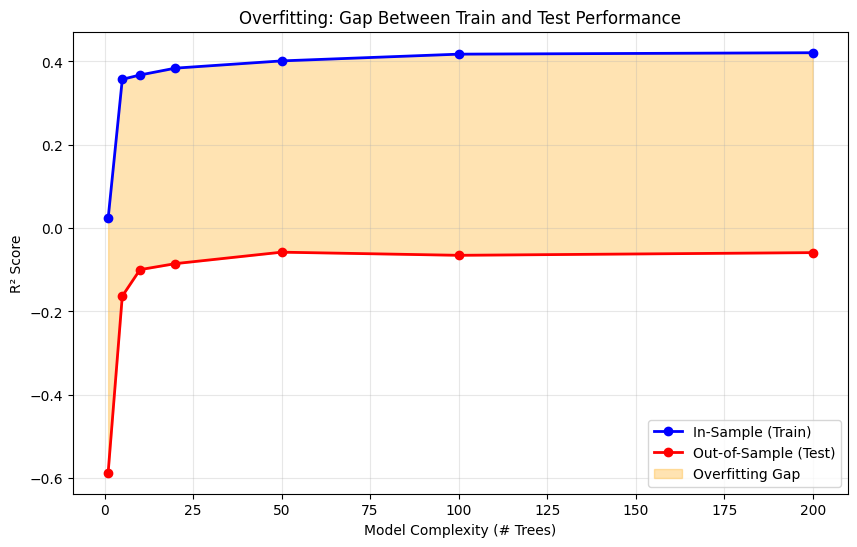


💡 KEY INSIGHT: More complexity → better train, worse test!


In [3]:
def demonstrate_overfitting():
    """
    Show how model complexity leads to overfitting
    """
    X = df[['momentum', 'volatility', 'volume', 'sentiment']].values
    y = df['target'].values
    
    # Split: 80% train, 20% test (time-based)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    # Test different model complexities
    complexities = [1, 5, 10, 20, 50, 100, 200]
    results = []
    
    for n_trees in complexities:
        model = RandomForestRegressor(
            n_estimators=n_trees,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        
        # In-sample performance
        pred_train = model.predict(X_train)
        r2_train = r2_score(y_train, pred_train)
        
        # Out-of-sample performance
        pred_test = model.predict(X_test)
        r2_test = r2_score(y_test, pred_test)
        
        results.append({
            'complexity': n_trees,
            'r2_train': r2_train,
            'r2_test': r2_test,
            'gap': r2_train - r2_test
        })
    
    return pd.DataFrame(results)

results = demonstrate_overfitting()

print("📊 OVERFITTING DEMONSTRATION")
print("=" * 60)
print(results.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results['complexity'], results['r2_train'], 'b-o', label='In-Sample (Train)', linewidth=2)
ax.plot(results['complexity'], results['r2_test'], 'r-o', label='Out-of-Sample (Test)', linewidth=2)
ax.fill_between(results['complexity'], results['r2_train'], results['r2_test'], alpha=0.3, color='orange', label='Overfitting Gap')
ax.set_xlabel('Model Complexity (# Trees)')
ax.set_ylabel('R² Score')
ax.set_title('Overfitting: Gap Between Train and Test Performance')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print("\n💡 KEY INSIGHT: More complexity → better train, worse test!")

## 4. Multiple Testing Problem

### The Issue

When you test many strategies, some will be "significant" by chance.

**Example:**
- Test 100 random strategies
- 5% significance level
- Expect ~5 to look significant even if all are random!

📊 MULTIPLE TESTING PROBLEM
Strategies tested: 100 (ALL ARE RANDOM!)

'Significant' at 5% level: 4 strategies
'Significant' at 1% level: 1 strategies

Best 'strategy' Sharpe: 2.54

⚠️ These 'significant' results are all due to CHANCE!


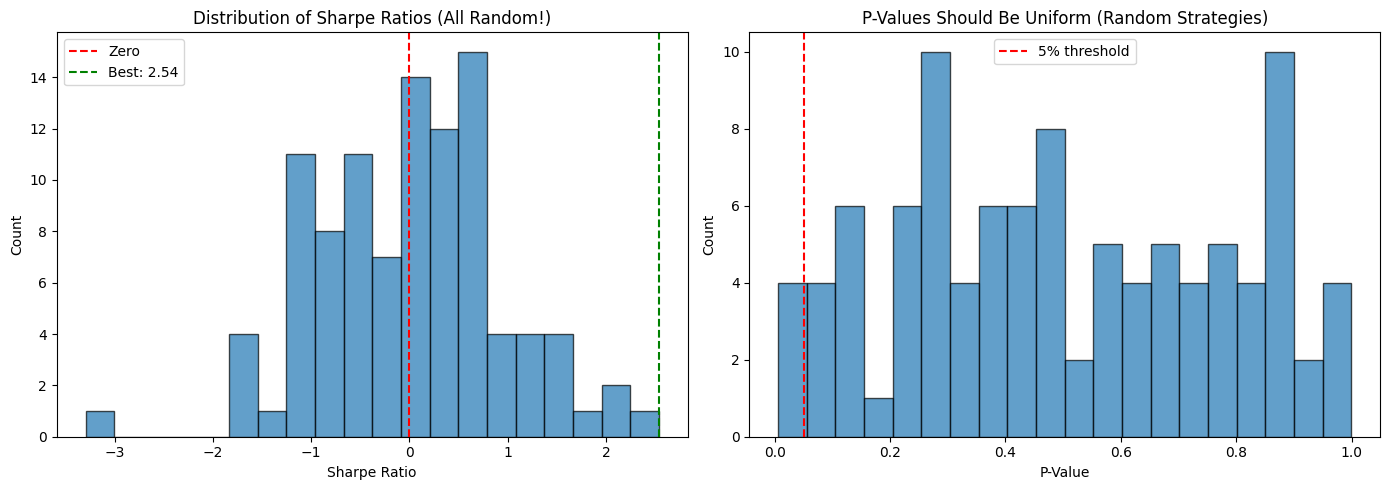

In [4]:
def multiple_testing_simulation(n_strategies=100, n_days=252):
    """
    Simulate the multiple testing problem
    """
    np.random.seed(42)
    
    # Generate random strategies (all are actually noise)
    sharpe_ratios = []
    p_values = []
    
    for _ in range(n_strategies):
        # Random returns (no real signal)
        returns = np.random.randn(n_days) * 0.01
        
        # Calculate Sharpe
        sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252)
        sharpe_ratios.append(sharpe)
        
        # t-test for Sharpe > 0
        t_stat = sharpe * np.sqrt(n_days) / np.sqrt(252)
        p_value = 1 - stats.t.cdf(t_stat, n_days - 1)
        p_values.append(p_value)
    
    # Count "significant" strategies
    n_significant_5pct = sum(1 for p in p_values if p < 0.05)
    n_significant_1pct = sum(1 for p in p_values if p < 0.01)
    
    return {
        'n_strategies': n_strategies,
        'n_significant_5pct': n_significant_5pct,
        'n_significant_1pct': n_significant_1pct,
        'best_sharpe': max(sharpe_ratios),
        'sharpe_ratios': sharpe_ratios,
        'p_values': p_values
    }

results = multiple_testing_simulation(n_strategies=100)

print("📊 MULTIPLE TESTING PROBLEM")
print("=" * 60)
print(f"Strategies tested: {results['n_strategies']} (ALL ARE RANDOM!)")
print(f"\n'Significant' at 5% level: {results['n_significant_5pct']} strategies")
print(f"'Significant' at 1% level: {results['n_significant_1pct']} strategies")
print(f"\nBest 'strategy' Sharpe: {results['best_sharpe']:.2f}")
print("\n⚠️ These 'significant' results are all due to CHANCE!")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sharpe distribution
axes[0].hist(results['sharpe_ratios'], bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--', label='Zero')
axes[0].axvline(x=results['best_sharpe'], color='g', linestyle='--', label=f'Best: {results["best_sharpe"]:.2f}')
axes[0].set_xlabel('Sharpe Ratio')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Sharpe Ratios (All Random!)')
axes[0].legend()

# P-value distribution
axes[1].hist(results['p_values'], bins=20, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0.05, color='r', linestyle='--', label='5% threshold')
axes[1].set_xlabel('P-Value')
axes[1].set_ylabel('Count')
axes[1].set_title('P-Values Should Be Uniform (Random Strategies)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [5]:
def bonferroni_correction(p_values, alpha=0.05):
    """
    Apply Bonferroni correction for multiple testing
    """
    n_tests = len(p_values)
    corrected_alpha = alpha / n_tests
    
    # Significant after correction
    significant = [p < corrected_alpha for p in p_values]
    
    return {
        'original_alpha': alpha,
        'corrected_alpha': corrected_alpha,
        'n_significant_original': sum(1 for p in p_values if p < alpha),
        'n_significant_corrected': sum(significant)
    }

correction = bonferroni_correction(results['p_values'])

print("📊 BONFERRONI CORRECTION")
print("=" * 60)
print(f"Original alpha: {correction['original_alpha']:.2%}")
print(f"Corrected alpha: {correction['corrected_alpha']:.4%}")
print(f"\nSignificant without correction: {correction['n_significant_original']}")
print(f"Significant with correction: {correction['n_significant_corrected']}")
print("\n✅ Correction properly filters out false discoveries!")

📊 BONFERRONI CORRECTION
Original alpha: 5.00%
Corrected alpha: 0.0500%

Significant without correction: 4
Significant with correction: 0

✅ Correction properly filters out false discoveries!


## 5. Strategy Decay Detection

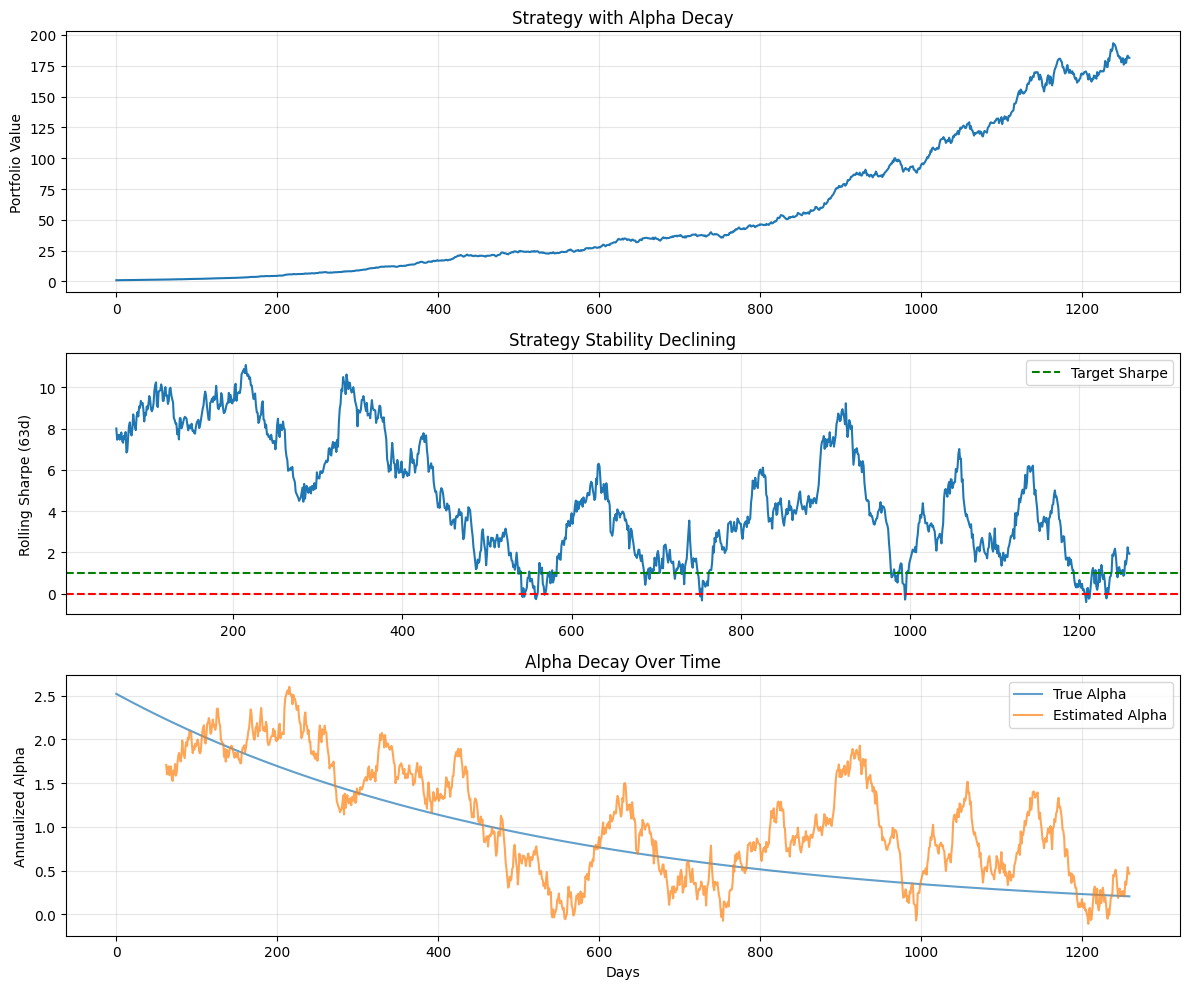

💡 KEY INSIGHT: Strategies decay as edge gets arbitraged away!
   Monitor rolling metrics to detect decay early.


In [6]:
def simulate_strategy_decay():
    """
    Simulate a strategy that decays over time (alpha decay)
    """
    np.random.seed(42)
    n_years = 5
    n_days = 252 * n_years
    
    # Strategy alpha decays exponentially
    time = np.arange(n_days)
    alpha_decay = 0.01 * np.exp(-time / (252 * 2))  # Half-life of 2 years
    
    # Generate returns with decaying alpha
    noise = np.random.randn(n_days) * 0.015
    strategy_returns = alpha_decay + noise
    
    # Calculate rolling metrics
    window = 63  # 3 months
    
    rolling_sharpe = pd.Series(strategy_returns).rolling(window).apply(
        lambda x: x.mean() / x.std() * np.sqrt(252) if x.std() > 0 else 0
    )
    
    rolling_alpha = pd.Series(strategy_returns).rolling(window).mean() * 252
    
    return {
        'returns': strategy_returns,
        'true_alpha': alpha_decay,
        'rolling_sharpe': rolling_sharpe,
        'rolling_alpha': rolling_alpha
    }

decay_results = simulate_strategy_decay()

# Visualize
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Cumulative returns
cumulative = (1 + pd.Series(decay_results['returns'])).cumprod()
axes[0].plot(cumulative.values)
axes[0].set_ylabel('Portfolio Value')
axes[0].set_title('Strategy with Alpha Decay')
axes[0].grid(True, alpha=0.3)

# Rolling Sharpe
axes[1].plot(decay_results['rolling_sharpe'].values)
axes[1].axhline(y=1, color='g', linestyle='--', label='Target Sharpe')
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_ylabel('Rolling Sharpe (63d)')
axes[1].set_title('Strategy Stability Declining')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# True vs estimated alpha
axes[2].plot(decay_results['true_alpha'] * 252, label='True Alpha', alpha=0.7)
axes[2].plot(decay_results['rolling_alpha'].values, label='Estimated Alpha', alpha=0.7)
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Annualized Alpha')
axes[2].set_title('Alpha Decay Over Time')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 KEY INSIGHT: Strategies decay as edge gets arbitraged away!")
print("   Monitor rolling metrics to detect decay early.")

## 6. ⏱️ TIMED CODING CHALLENGE (30 minutes)

**Challenge:** Build a function that:
1. Takes a set of strategy returns
2. Tests for statistical significance with multiple testing correction
3. Detects alpha decay using structural break tests
4. Returns a comprehensive diagnostic report

In [7]:
# YOUR CODE HERE
def strategy_diagnostic(returns, confidence_level=0.95):
    """
    Comprehensive strategy diagnostic
    
    Parameters:
    -----------
    returns : array-like
        Strategy returns
    confidence_level : float
        Confidence level for statistical tests
        
    Returns:
    --------
    dict : Diagnostic results
    """
    # TODO: Implement
    # 1. Test statistical significance
    # 2. Check for alpha decay
    # 3. Identify structural breaks
    # 4. Generate report
    pass

# Test your implementation
# diagnostic = strategy_diagnostic(decay_results['returns'])

## 7. Interview Question of the Day

**Q: How would you distinguish between a strategy that has decayed vs one that was overfitted from the start?**

Think about:
1. Out-of-sample vs post-deployment performance
2. Pattern of decay (sudden vs gradual)
3. Market conditions during backtest vs live

In [8]:
print("📊 OVERFITTING vs DECAY: KEY DIFFERENCES")
print("=" * 70)

comparison = pd.DataFrame({
    'Aspect': [
        'Initial live performance',
        'Decay pattern',
        'Recovery possibility',
        'Backtest characteristics',
        'Fix'
    ],
    'Overfitting': [
        'Poor immediately',
        'N/A - never worked',
        'Very unlikely',
        'Too good to be true',
        'Simplify model, more data'
    ],
    'Alpha Decay': [
        'Good initially',
        'Gradual decline',
        'Possible with adaptation',
        'Reasonable, matched reality',
        'Find new signals, adapt'
    ]
})

print(comparison.to_string(index=False))

📊 OVERFITTING vs DECAY: KEY DIFFERENCES
                  Aspect               Overfitting                 Alpha Decay
Initial live performance          Poor immediately              Good initially
           Decay pattern        N/A - never worked             Gradual decline
    Recovery possibility             Very unlikely    Possible with adaptation
Backtest characteristics       Too good to be true Reasonable, matched reality
                     Fix Simplify model, more data     Find new signals, adapt


## 8. Key Takeaways

| Pitfall | Description | Prevention |
|---------|-------------|------------|
| Lookahead | Using future data | Strict point-in-time |
| Overfitting | Fitting noise | Walk-forward, regularization |
| Multiple Testing | False discoveries | Bonferroni, FDR correction |
| Alpha Decay | Edge disappears | Monitor, adapt |
| Survivorship | Ignoring failures | Include dead stocks |

---

**Tomorrow:** Full Backtest Pipeline